In [ ]:
import numpy as np
import copy
import torch
import itertools
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, Normal
from torch.optim.lr_scheduler import LambdaLR, ConstantLR, CyclicLR
from torch.autograd import Variable
from scipy.optimize import root_scalar, shgo
import networkx as nx

device = "cpu"
default_tensor_type = torch.FloatTensor

# Problem Setting

The Objective of this notebook is to study the compromise Performance vs Robustness of Statistics over distributions of Rankings

We need to define an indexation order on $\mathfrak{S}_n$ in order to write the loss as a matrix in $\mathbb{R}^{n! \times n!}$ and distributions as vectors in $\mathbb{R}^{n!}$.

In [ ]:
n_items = 8
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

**DEFINITION:** A statistics over a distribution of rankings is a function $T:\Delta^{\mathfrak{S}_n} \to \mathfrak{S}_n$.

**PERFORMANCE** as defined by 
$$
p \mapsto \mathbb{E}_{Y\sim p}\left(\tau_K(Y, T(p))\right)
$$
where 
$\tau_K$ is the Kendall Tau:
$$
\tau_K(y, \sigma) = \sum_{i,j} \mathbb{1}\{\sigma^{-1}(i) < \sigma^{-1}(j)\}\mathbb{1}\{y^{-1}(i) > y^{-1}(j)\}
$$

In [ ]:
def pairwise_marginals_cached(p, all_pairwises):
    return np.tensordot(p, all_pairwises, axes=(0,0))

def pairwise_preference(sigma):
    inv = np.argsort(sigma)[:,np.newaxis]
    return (inv < inv.T).astype(float)

def pairwise_matrix(p_torch, torch_all_ranks, n=4):
    #M = torch.zeros(n,n)
    #for i in range(n):
    #    for j in range(i+1,n):
    #        idxs = torch.tensor([torch.argwhere(rk == i).item() < torch.argwhere(rk == j).item() for rk in torch_all_ranks])
    #        val = torch.sum(p_torch[0,idxs]).item()
    #        M[i,j] = val
    #        M[j,i] = 1-val
    all_rank = torch_all_ranks.detach().numpy()
    all_pairwises = np.array([pairwise_preference(sigma) for sigma in all_rank])
    if torch.is_tensor(p_torch):
        p = p_torch.squeeze().detach().numpy()
    else:
        p = p_torch.squeeze()
    M = pairwise_marginals_cached(p, all_pairwises)
    return torch.tensor(M)


def expected_kendall(P1, P2):
    P1 = P1 - torch.diag(torch.diag(P1))
    P2 = P2 - torch.diag(torch.diag(P2))
    return torch.norm(P1 * (1-P2), 1)


**ROBUSTNESS** as defined by the "breakdown function" of T:
$$
\varepsilon^*(\delta,p,T) = \inf \left\{\varepsilon>0 : \sup_{||p-q|| \leq \varepsilon} \rho_{\tau_K}(T(p), T(q)) \geq \delta \right\}
$$
where
$$
\rho_{\tau_K} = H_K^{(1/2)}(\pi_1, \pi_2) := \frac{1}{2}\left(\max_{\sigma_1 \in \pi_1} \min_{\sigma_2 \in \pi_2} \tau_K(\sigma_1, \sigma_2) + \max_{\sigma_2 \in \pi_2} \min_{\sigma_1 \in \pi_1} \tau_K(\sigma_1, \sigma_2) \right)
$$
The difficulty with the computation of the breakdown function is that the underlying optimization cannot be performed directly.

In [ ]:
def symmetrized_hausdorff_on_kendall(P1, P2):
    return torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1)

$$
\tilde{\rho}_{\tau_K} = H_K^{dis}(\pi_1, \pi_2) := \max_{\sigma_2 \in \pi_2} \min_{\sigma_1 \in \pi_1} \tau_K(\sigma_1, \sigma_2)
$$

In [ ]:
def disymmetrized_hausdorff_on_kendall(P1, P2):
    # If P2 is included in P1
    if (P1[P1 != 1/2] == P2[P1 != 1/2]).all():
        return torch.tensor(0.0)
    # If P1 is included in P2
    elif (P1[P2 != 1/2] == P2[P2 != 1/2]).all():
        return 2*torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1)
    else:
        idxs = torch.argwhere(P1 == 1/2)
        v = torch.sum(P2 == 1/2)/2
        idxs2 = torch.argwhere(P2 == 1/2)
        P1[[idxs[:, 0], idxs[:, 1]]] = 0
        P2[[idxs[:, 0], idxs[:, 1]]] = 0
        P1[[idxs2[:, 0], idxs2[:, 1]]] = 0
        P2[[idxs2[:, 0], idxs2[:, 1]]] = 0
        return torch.norm(torch.triu(P1,1) - torch.triu(P2,1), 1) + v

# Computing the breakdown function

We approximate the computation of $\varepsilon^*$ in the following way:

1. We find a distribution $\tilde q_{\varepsilon,\delta, p, T}$ that is a solution of the smoothed problem:
$$
\tilde q_{\varepsilon, p, T} = \arg\sup_{||p-q|| \leq \varepsilon} \phi(p,q)
$$
where $\phi(\cdot,q) = \rho_{\tau_K}(T(\cdot), T(q)) \star k(\cdot)$ with $k$ being a smoothing convolution kernel, here a multivariate Gaussian.
2. We approximate $\varepsilon^*$ by
$$
\tilde\varepsilon(\delta,p,T) = \inf \left\{\varepsilon>0 : \rho_{\tau_K}\left(T(p), T(\tilde q_{\varepsilon, p, T})\right) \geq \delta \right\}
$$

### Computing $\phi$

A method for smoothing a bivariate function $m:{\cal Y}\times {\cal X} \to \mathbb{R}$ on its second argument using a mean convolution with kernel $k$.

$$
\tilde m(y, x) = (m(y,\cdot)\star k)(x)
$$

In [ ]:
def smooth_pg_2(m, k_x):
    r"""
    Smooth a metric $m$ by convolution with a kernel $k_x$ centered in $x$.
    $$\tilde{m}(y,x) = \int m(y,u) k_x(u) du$$
    As the gradient is not available in closed-form, the loss build is a policy gradient loss, that leads to a noisy but
    unbiased estimate of the gradient of $\tilde{m}$.
    $$g_x(y,u) = \log(k_x(u)) f(y,u) ~~~~\text{for}~~~ u\sim k_x$$
    :param m: function to be smoothed
    :param k_x: function $x\mapsto k$ where $k$ is a kernel centered in $x$
    :return: $g_x(y,u)$ for $u\sim k_x$
    """
    def smoothed_m_pg(y, x):
        k = k_x(x)
        batch_size = torch.Size()
        if len(y.size()) > 1:
            batch_size = y.size()[:-1]
        u = k.sample(batch_size).to(device).type(default_tensor_type)
        loss = k.log_prob(u) * m(y,u)
        return loss
    
    return smoothed_m_pg

In [ ]:
def monte_carlo_phi(p, q, dist_Tp_Tq, std_dev_=0.00001, nb_simu=50):
    kernel_conv = lambda _s: MultivariateNormal(_s, std_dev_*torch.eye(_s.size()[-1]))
    rhos = list()
    for i in range(nb_simu):
        q2 = kernel_conv(q.float()).sample(torch.Size())
        rho = dist_Tp_Tq(p, q2.unsqueeze(0)).detach().numpy().item()
        rhos.append(rho)
    rho_final = np.mean(rhos)
    return torch.tensor(rho_final)

In [ ]:
class NewPhi(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    def __init__(self):
        self.name = "New Phi class"

    @staticmethod
    def forward(ctx, input_q2, input_backward, p_torch, dist_Tp_Tq, std_dev_, nb_simu):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input_backward)
        monte_carlo_val = monte_carlo_phi(p_torch, input_q2, dist_Tp_Tq, std_dev_=std_dev_, nb_simu=nb_simu)
        return monte_carlo_val

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        back_,  = ctx.saved_tensors
        return back_ * grad_output, None, None, None, None, None

### Computing $\tilde q_{\varepsilon,\delta, p, T}$

Remember we want to compute
$$
\tilde q_{\varepsilon, p, T} = \arg\sup_{||p-q|| \leq \varepsilon} \phi(p,q)
$$
Practically, we solved the Lagrangian relaxation of this
$$
\tilde q_{\lambda, p, T} = \arg\sup_q \phi(p,q) - \lambda ||p-q||
$$

In [ ]:
def torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, reg, epochs, std_dev=0.01, lr=0.01):
    r"""
    :param method: $\tau_K(T(p), T(q))$
    :param reg: $\lambda$
    :param epochs: limit on the number of optimization iterations
    """
    p_torch2 = p_torch.detach().clone()
    p_torch2.requires_grad = False
    softmax = torch.nn.Softmax(dim=0)
    softplus = torch.nn.Softplus(beta=1, threshold=20)
    kernel_conv = lambda _s: MultivariateNormal(_s, std_dev*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
    smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)     # $\phi(.,.)$
    
    s_ = p_torch[0,:].detach().clone().to(device).type(default_tensor_type)
    s_.requires_grad = True
    optimizer = torch.optim.SGD([s_], lr=0.01, momentum=0.9)
    scheduler = CyclicLR(optimizer, 0.01, 1.0, step_size_down=50, cycle_momentum=False)

    for epoch in range(epochs):
        optimizer.zero_grad()
        q = softmax(s_)                                # projection $\sum = 1$
        
        # Decrease the approximation error over time
        kernel_conv = lambda _s: MultivariateNormal(_s, std_dev*(10/(10+epoch))*torch.eye(_s.size()[-1])) # $x\mapsto k_x(.)$
        smoothed_dist_Tp_Tq = lambda p, q: smooth_pg_2(dist_Tp_Tq, kernel_conv)(p, q)     # $\phi(.,.)$
        
        loss = -smoothed_dist_Tp_Tq(p_torch2, q) + reg*(torch.norm(p_torch2-q, 1))     # Lagrangian relaxation of the objective
        loss.backward()
        optimizer.step()
        scheduler.step()
        

    return q

### Computing $
\tilde\varepsilon(\delta,p,T) = \inf \left\{\varepsilon>0 : \rho_{\tau_K}\left(T(p), T(\tilde q_{\varepsilon, p, T})\right) \geq \delta \right\}
$

First strategy: using $\rho_{\tau_K}$ in the evaluation of the breakdown point. Cons: piecewise-constant function, unstable results in the end.

Second strategy: using $\phi$ (the smoothed version of $\rho_{\tau_K}$). Cons: it seems the results are weird.

#### Monte-Carlo estimation of rho when using $\phi$

$\phi(p,q) = \rho_{\tau_K}(T(p), T(q)) \star k(p) = \int_u \rho_{\tau_K}(T(u), T(q)) \times k(p-u) du = \int_u \rho_{\tau_K}(T(u), T(q)) \times k_p(u) du = \mathbb{E}_{p' \sim k_p}(\rho_{\tau_K}(T(p'), T(q)))$ 

#### Implementation of the function to compute the breakdown point.

###### FIRST IMPLEMENTATION (OUTDATED)

We want to solve the following pb:

$$\inf_{\varepsilon \geq 0} \varepsilon \text{ s.t. } \sup_{||p-q|| \leq \varepsilon} \rho_T(p,q) \geq \delta$$

This problem is equivalent to the following one, based one Lagrange relaxation:

$$ \inf_{\varepsilon \geq 0} \, \sup_{\lambda \geq 0} \, \inf_{q \in \Delta} \, \sup_{\alpha \geq 0} \, \, \varepsilon + \lambda \delta - \lambda \rho_T(p,q) + \alpha \lambda ||p-q|| - \lambda \alpha \varepsilon $$

To make it easy to follow, here is what each variable is controling:

1) $q$ is the attacking probability vector, which should not be too far from $p$, but change statistics $T$

2) $\varepsilon$ is the attack budget (the breakdown point) controling the perturbation from $q$

3) $\lambda$ controls that the statistics $T$ is indeed broken by at least $\delta$ by $q$

4) $\alpha$ controls that $q$ is indeed closer than $\varepsilon$ from $p$

##### CURRENT IMPLEMENTATION - SIMPLIFICATION

The previous problem can be re-writtem in a simple form:

$$\inf_{q \in \Delta} \sup_{\lambda > 0} || p-q || + \lambda (\delta - \rho_T(p,q))$$

Where $\lambda$ controls that the statistic is indeed broken by at least $\delta$

In [ ]:
def subsample_fct(vect, time=10):
    l = len(vect)
    res = vect[0:l:time]
    return res

def custom_scheduler(my_optimizer, lr, grad_data):
    if (torch.abs(grad_data) > 20).any():
        my_optimizer.param_groups[0]['lr'] = lr/100
    elif (torch.abs(grad_data) > 1.5).any():
        my_optimizer.param_groups[0]['lr'] = lr*torch.log(torch.mean(torch.abs(grad_data)))/10
    elif (torch.abs(grad_data) > 0.5).any():
        my_optimizer.param_groups[0]['lr'] = lr*torch.mean(torch.abs(grad_data))/1
    else:
        my_optimizer.param_groups[0]['lr'] = 10*lr
    return my_optimizer

def plot_end_training(p_torch, dist_Tp_Tq, norms_, losses, mean_qs_, phis_, mean_phi2_, lambdas_, mean_lambdas_, grad_data, freq_phi_, norm_type):
    f, ax = plt.subplots(2,2, figsize=(15, 8))
    ax[0,0].plot(norms_)
    #ax[0,0].set_ylim([-0.05, 2.05])
    ax[0,0].set_title(f"Norm diff btw p and q")

    ax[0,1].plot(phis_)
    ax[0,1].set_ylim([-0.05, 6.05])
    ax[0,1].set_title(f"Phi")
    
    ax[1,0].plot(lambdas_)
    #ax[1,0].set_ylim([-0.05, 8.05])
    ax[1,0].set_title(f"Lambda")

    ax[1,1].plot(losses)
    #ax[1,1].set_ylim([-10.05, 10.05])
    ax[1,1].set_title(f"Loss")
    plt.show()
        
    print("\n \n")
    time_fct = 100
    x_axis_val = subsample_fct(np.linspace(0,len(mean_lambdas_),len(mean_lambdas_)), time=time_fct)
    f, ax = plt.subplots(2,2, figsize=(15, 8))

    mean_qs_subsample = subsample_fct(mean_qs_, time_fct)
    mean_qs1_ = [torch.norm(p_torch - torch.tensor(mean_q_), int(norm_type)) for mean_q_ in mean_qs_subsample] #[mean_q_[0] for mean_q_ in mean_qs_]
    ax[0,0].plot(x_axis_val, mean_qs1_)
    #ax[0,0].set_ylim([-0.05, 1.05])
    ax[0,0].set_title(f"Norm of the difference between p and q")

    Phi_ = NewPhi.apply
    mean_phis_ = [Phi_(torch.tensor(mean_q_), grad_data, p_torch, dist_Tp_Tq, 1e-7, 100) for mean_q_ in mean_qs_subsample]
    ax[0,1].plot(x_axis_val, mean_phis_, label="from mean q")
    ax[0,1].plot(x_axis_val, subsample_fct(mean_phi2_, time_fct), label="from phis")
    ax[0,1].legend()
    ax[0,1].set_ylim([-0.05, 6.05])
    ax[0,1].set_title(f"Phi")
    
    ax[1,0].plot(x_axis_val, subsample_fct(mean_lambdas_, time_fct))
    ax[1,0].set_title(f"Lambda")
    
    ax[1,1].plot(x_axis_val, subsample_fct(losses, time_fct))
    ax[1,1].set_title(f"Loss")
    plt.plot()
    
    print(f"Phi freq: {freq_phi_}")
    

def approximate_breakdown_function(delta, dist_Tp_Tq, p_torch, epochs=150000, std_dev=0.01, lr=0.01, maxiter=10, max_reg=10., eval_strat="real", norm_type="1", ratio_norm_=1.0, nb_simu_training=25):
    softmax = torch.nn.Softmax(dim=0)
    softplus = torch.nn.Softplus(beta=1, threshold=20)
    #q = torch_optim_attack_relaxed(dist_Tp_Tq, p_torch, epochs=20, std_dev=std_dev, reg=10, lr=0.01)
    #q2 = q.detach().clone()
    q2 = p_torch.detach().clone().squeeze(0) #q.detach().clone() #
    q2.requires_grad = True
    s_ = q2[:].detach().clone().to(device).type(default_tensor_type)
    s_.requires_grad = True

    lambda_ = torch.tensor((10.0,), requires_grad=True)
    qs_ = list()
    qs_total_ = list()
    lambdas_ = list()
    norms_ = list()
    
    mean_qs_ = list()
    mean_phi2_ = list()
    mean_lambdas_ = list()
    
    freq_phi_ = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}

    phis_ = list()
    losses = list()

    lr_list = list()

    optimizer_q2 = torch.optim.SGD([s_], lr=lr, weight_decay=0.01, momentum=0.1)
    optimizer_lambda = torch.optim.SGD([lambda_], lr=lr, weight_decay=0.01, momentum=0.1, maximize=True)
    
    scheduler_q2 = torch.optim.lr_scheduler.LinearLR(optimizer_q2, start_factor=1, end_factor=1/20, total_iters=30000)
    scheduler_lambda = torch.optim.lr_scheduler.LinearLR(optimizer_lambda, start_factor=1, end_factor=1/20, total_iters=30000)

    for epoch in range(epochs):
        try:
            std_dev_training = 1e-5
            kernel_conv = lambda _s: MultivariateNormal(_s, std_dev_training*torch.eye(_s.size()[-1]))
            q2 = softplus(s_)/torch.sum(softplus(s_))
            res = smooth_pg_2(dist_Tp_Tq, kernel_conv)(p_torch, q2)
            res.backward(retain_graph=True)
            grad_data = s_.grad.data.detach().clone()
            Phi_ = NewPhi.apply
            phi_ = Phi_(q2, grad_data, p_torch, dist_Tp_Tq, std_dev_training, nb_simu_training)
            
            # Norm: L1, L2, or something between the two
            norm_ = ratio_norm_*torch.norm(p_torch - torch.unsqueeze(q2,0), int(norm_type)) + (1.0-ratio_norm_)*torch.norm(p_torch - torch.unsqueeze(q2,0), 2*int(norm_type) - 3*(int(norm_type)-1))

            optimizer_q2.zero_grad()
            optimizer_lambda.zero_grad()

            # LOSS
            loss = norm_ + lambda_*delta - lambda_*phi_
            
            loss.backward()
            optimizer_q2.step()
            optimizer_lambda.step()
            scheduler_q2.step()
            scheduler_lambda.step()
            
            with torch.no_grad():
                lambda_[:] = lambda_.clamp(min=0.0, max=None)

            if epoch % (epochs/100) == 0:
                print(f"EPOCH {epoch}: \n \t q2={q2} \n \t s_={s_} \n \t grad = {-s_.grad.data} \n \t lr = {optimizer_q2.param_groups[0]['lr']} \n \t phi = {phi_} and std_dev = {std_dev_training} and norm diff = {norm_} \n \n \t lambda_={lambda_} and grad = {lambda_.grad.data} \n \t lr = {optimizer_lambda.param_groups[0]['lr']}")
            losses.append(loss.detach().item())
            qs_total_.append(q2.detach().numpy())
            norms_.append(norm_.item())
            
            phis_.append(phi_.item())
            lambdas_.append(lambda_.detach().item())

            if phi_.item() in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]:
                freq_phi_[np.round(phi_.item())] += 1
            lr_list.append(optimizer_q2.param_groups[0]['lr'])

            if epoch == 0:
                mean_qs_.append(qs_total_[-1])
                mean_phi2_.append(phis_[-1])
                mean_lambdas_.append(lambdas_[-1])
            else:
                mean_qs_.append( (epoch+1)/(epoch+2)*mean_qs_[-1] + 1/(epoch+2)*qs_total_[-1] ) #mean_qs_.append(np.mean(qs_total_[0:], axis=0))
                mean_lambdas_.append( (epoch+1)/(epoch+2)*mean_lambdas_[-1] + 1/(epoch+2)*lambdas_[-1] ) #mean_etas_.append(np.mean(etas_[0:]))
                mean_phi2_.append( (epoch+1)/(epoch+2)*mean_phi2_[-1] + 1/(epoch+2)*phis_[-1] )
        except:
            print(f"Something went wrong")
            print(f"EPOCH {epoch}: \n \t q2={q2} \n \t s_={s_} and grad = {-s_.grad.data} \n \t lr = {optimizer_q2.param_groups[0]['lr']} \n \t phi = {phi_} and std_dev = {1.0/(1+epoch)} \n \n \t lambda_={lambda_} and grad = {lambda_.grad.data} \n \t lr = {optimizer_lambda.param_groups[0]['lr']}")
            break

    return norms_, losses, s_, qs_total_, mean_qs_, phis_, mean_phi2_, lambdas_, mean_lambdas_, grad_data, freq_phi_ #losses, qs_, lambdas_, s_, mean_qs_, mean_lambdas_ #epsilons_, etas_, alphas_, s_, mean_qs_, mean_epsilons_, mean_etas_, mean_alphas_
    

# Family of distribution

The Plackett-Luce model is a parametric family of distributions over permutations:
$$
\mathbb{P}\left(\sigma | w\right) = \prod_{r=1}^n \frac{w_{\sigma(r)}}{\sum_{k\geq r}w_{\sigma(k)}}
$$

In [ ]:
from numba import jit
#@jit
def proba_plackett_luce(w, all_ranks, n_items=4):
    list_proba = list()

    for sigma in all_ranks:
        val_ = list()
        for r in range(n_items):
            num_ = w[sigma[r]]
            denom_ = 0
            for s in range(r, n_items):
                v_ = w[sigma[s]]
                denom_ += v_
            val_.append(num_/denom_)
        proba_ = np.prod(val_)
        list_proba.append(proba_)
    return np.matrix(list_proba)

# Statistics under study

### MaxPair

Todo: add a description

In [ ]:
def _maxpair(P, threshold = 0.):
    s = torch.sum(1*(P > 0.5)+1/2*(P == 0.5), axis=1)
    sigma = torch.argsort(-s)
    M = P[np.ix_(sigma,sigma)]
    
    idxs = torch.argwhere(M>1/2+threshold)
    for idx in idxs:
        M[:idx[0]+1,idx[1]] = 1
        M[idx[1],:idx[0]+1] = 0

    m = torch.max(torch.abs(M-0.5)*(M!=0.5)*(torch.abs(M-0.5) <= threshold))
    while m > 0:
        i,j = torch.argwhere(np.abs(M-0.5) == m)[0]
        if i <= j:
            idx_tomerge1, idx_tomerge2 = i, j+1
        elif i > j:
            idx_tomerge1, idx_tomerge2 = j, i+1
        M = torch_merge_idx(M, torch.arange(idx_tomerge1,idx_tomerge2))
        m = torch.max(np.abs(M - 0.5) * (M != 0.5) * (torch.abs(M - 0.5) <= threshold))
    return M[np.ix_(torch.argsort(sigma), torch.argsort(sigma))]

def maxpair(p, torch_all_ranks, n=4, threshold = 0.):
    P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    return _maxpair(P, threshold = threshold)

### Merge

Todo: add a description

In [ ]:
from numba import njit

@torch.jit.script #@njit
def torch_merge_idx(M, idx):
    # i,j \notin idx -> P_ij = M_ij
    # i \in idx, j \notin idx -> P_ij = \max_{k\in idx} M_kj
    # i \notin idx, j \in idx -> P_ij = \max_{k\in idx} M_ik
    # i,j \in idx -> P_ij = 0.5
    P = M
    for i in torch.arange(M.shape[0]):
        m = torch.max(M[i, idx])
        for j in idx:
            P[i,j] = m
    for j in torch.arange(M.shape[0]):
        m = torch.max(M[idx, j])
        for i in idx:
            P[i,j] = m
    for i in idx:
        for j in idx:
            P[i,j] = 0.5
    PTRIU = torch.triu(P, 0)
    P = PTRIU + torch.tril(1 - PTRIU.T, -1)
    return P

#@torch.jit.script #@njit
def merge(p, torch_all_ranks, threshold=0, n=4):
    P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    cont = True
    while cont:
        P_mod = torch.abs(torch.triu(P,1)-torch.tensor(0.5))
        m = torch.min(torch.abs(torch.triu(P,1)-torch.tensor(0.5)))
        if m == 0.0 or m > threshold:
            cont = False
        else:
            idxs = torch.argwhere(P_mod == m)
            idxs = idxs.reshape(torch.prod(torch.tensor(idxs.shape)))
            P = torch_merge_idx(P, idxs)
    return P

### ERM

Todo: add a description

In [ ]:
def erm(p, torch_all_ranks, n=4):
    P = pairwise_matrix(p, torch_all_ranks=torch_all_ranks, n=n)
    return torch.round(P)

### Depth

Todo: add a description

Only available for n=4 items

In [ ]:
def kendall_tau(sigma1, sigma2):
    n = sigma1.size()[-1]
    sigma1_inv = torch.argsort(sigma1, dim=-1)
    sigma2_inv = torch.argsort(sigma2, dim=-1)
    sigma1_pairs = (sigma1_inv.unsqueeze(dim=-1) > sigma1_inv.unsqueeze(dim=-2)).float()
    sigma2_pairs = (sigma2_inv.unsqueeze(dim=-1) > sigma2_inv.unsqueeze(dim=-2)).float()
    return torch.sum(torch.abs(sigma1_pairs-sigma2_pairs), dim=[-2,-1]).double()/2 #/(n*(n-1))

def kendall_matrix(torch_all_ranks):
    K = torch.zeros(len(torch_all_ranks),len(torch_all_ranks))
    for i, rank1 in enumerate(torch_all_ranks):
        for j, rank2 in enumerate(torch_all_ranks):
            K[i,j] = kendall_tau(rank1,rank2)
    return K.double()

def get_all_buckets(torch_all_ranks, n=4):
    list_bucket = list()

    for rank1 in torch_all_ranks:
        for rank2 in torch_all_ranks:
            if kendall_tau(rank1,rank2) == 1.0:
                list_bucket.append( [rank1,rank2] )
    
    for i in np.arange(n):
        temp_ranks = list()
        for rank in torch_all_ranks:
            if rank[3] == i:
                temp_ranks.append(rank)
        list_bucket.append(temp_ranks)
        
    list_bucket.append([torch.tensor([0,1,2,3]), torch.tensor([0,1,3,2]),torch.tensor([1,0,2,3]),torch.tensor([1,0,3,2])])
    list_bucket.append([torch.tensor([0,2,1,3]), torch.tensor([0,2,3,1]),torch.tensor([2,0,1,3]),torch.tensor([2,0,3,1])])
    list_bucket.append([torch.tensor([0,3,1,2]), torch.tensor([0,3,2,1]),torch.tensor([3,0,1,2]),torch.tensor([3,0,2,1])])
    list_bucket.append([torch.tensor([1,2,0,3]), torch.tensor([1,2,3,0]),torch.tensor([2,1,0,3]),torch.tensor([2,1,3,0])]) 
    list_bucket.append([torch.tensor([1,3,0,2]), torch.tensor([1,3,2,0]),torch.tensor([3,1,0,2]),torch.tensor([3,1,2,0])])
    list_bucket.append([torch.tensor([2,3,0,1]), torch.tensor([2,3,1,0]),torch.tensor([3,2,0,1]),torch.tensor([3,2,1,0])])

    list_bucket.append(torch_all_ranks)
    for rank in torch_all_ranks:
        list_bucket.append(list([rank]))
    
    return list_bucket

def bucket_distrib(torch_all_ranks, list_bucket):
    l_ = list()
    div = len(list_bucket)
    for a_ in torch_all_ranks:
        count = 0
        for b_ in list_bucket:
            count += 1
            if (b_ == a_).all():
                l_.append(1.0/div)
                count += 1
                continue
        if count == div:
            l_.append(0)
    return torch.tensor(l_).double()

def depth_metric_optim(p, K, list_bucket, torch_all_ranks, norm="l1", printer=False):
    n_ranks_to_test = len(list_bucket)
    val = torch.inf
    for i, bucket in enumerate(list_bucket):
        q = bucket_distrib(torch_all_ranks, bucket)
        if norm == "l1":
            val_ = torch.norm(torch.matmul(p.double(),K) - torch.matmul(q.double(),K), 1)
        elif norm == "l2":
            val_ = torch.norm(torch.matmul(p.double(),K) - torch.matmul(q.double(),K), 2)
        if printer:
            print(f"val: {val_} for {bucket}")
        if val_ <= val:
            best_distrib = q
            val = val_
    return best_distrib, val

def depth(p, torch_all_ranks, norm="l1", printer=False):
    list_bucket = get_all_buckets(torch_all_ranks, n=4)
    K = kendall_matrix(torch_all_ranks)
    q, val = depth_metric_optim(p, K, list_bucket, torch_all_ranks, norm=norm, printer=printer)
    Q = pairwise_matrix(q.unsqueeze(0), torch_all_ranks=torch_all_ranks, n=4)
    return Q  
    

### Wasserstein

Todo: add a description

In [ ]:
from scipy import optimize
from math import factorial

def wasserstein_dist(p, q, K, n=4):
    nsize = factorial(n)
    K_bis = K.view(nsize*nsize)
    
    for i in range(nsize):
        A_ = [0]*nsize*i + [1]*nsize + [0]*nsize*(nsize-i-1)
        if i == 0:
            A = torch.tensor(A_).reshape(1,nsize*nsize)
        else:
            A = torch.cat((A, torch.tensor(A_).reshape(1,nsize*nsize)))
    for i in range(nsize):
        A_ = ([0]*i + [1] + [0]*(nsize-i-1))*nsize
        A = torch.cat((A, torch.tensor(A_).reshape(1,nsize*nsize)))
    
    b = torch.cat((p, q), 1)
    
    optim_val = optimize.linprog(K_bis, A_eq=A, b_eq=b, bounds=(0,1))
    return optim_val.fun

def wasserstein_(myp, torch_all_ranks, n=4, printer=False):
    list_bucket = get_all_buckets(torch_all_ranks, n=4)
    K = kendall_matrix(torch_all_ranks)
    val = torch.inf
    for i, bucket in enumerate(list_bucket):
        q = bucket_distrib(torch_all_ranks, bucket)
        if len(q.shape) < 2:
            q = q.unsqueeze(0)
        val_ = wasserstein_dist(myp, q, K, n=n)
        if val_ <= val:
            best_distrib = q
            val = val_
    return best_distrib, val

def wasserstein(myp, torch_all_ranks, n=4):
    q, val = wasserstein_(myp, torch_all_ranks, n=n, printer=False)
    Q = pairwise_matrix(q, torch_all_ranks=torch_all_ranks, n=n)
    return Q

### DRO

It corresponds to the optim pb: $ \min_{\sigma} \max_{q | q \in \mathcal{B}(p)} \mathbb{E}_{\Sigma \sim q}(d(\sigma, \Sigma))$ i.e. $$ \min_{\sigma} \max_{q \in \Delta} \min_{\lambda > 0} q^T D \sigma + \lambda(\epsilon - ||p-q||) $$


# Performance vs Robustness profile

In [ ]:
import os

def get_automatic_thresholds(w):
    p = proba_plackett_luce(w, all_ranks)
    p_torch = torch.from_numpy(p)
    torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
    P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
    print(f"Pairwise mat: \n {P}")

    m = torch.flatten(torch.triu(P, 1))
    m = torch.sort(m[m != 0.0])[0]
    #m = torch.cat((torch.tensor([0.5]), m), dim=-1)
    #l = [ ((m[i+1] + m[i])/2).numpy() - 0.5 for i in range(0, m.shape[0]-1)]
    #thresholds_ = np.unique(l)
    minval = (m - 0.5)[0]
    maxval = (m - 0.5)[-1]
    thresholds_ = [0]
    for val in list(np.linspace(minval-0.0005, maxval+0.0005, 21)):
        thresholds_.append(val)
    print(f"thresholds = {thresholds_}")
    return thresholds_

def torch_dist(dist, p_torch1, p_torch2, torch_all_ranks, threshold, dist_type_sym):
        if dist == "erm":
            R1 = erm(p_torch1, torch_all_ranks, n=4)
            R2 = erm(p_torch2, torch_all_ranks, n=4)
        elif dist == "maxpair":
            R1 = maxpair(p_torch1, torch_all_ranks, n=4, threshold=threshold)
            R2 = maxpair(p_torch2, torch_all_ranks, n=4, threshold=threshold)
        elif dist == "merge":
            R1 = merge(p_torch1, torch_all_ranks, threshold=threshold, n=4)
            R2 = merge(p_torch2, torch_all_ranks, threshold=threshold, n=4)
        elif dist == "depth":
            R1 = depth(p_torch1, torch_all_ranks, norm="l1", printer=False)
            R2 = depth(p_torch2, torch_all_ranks, norm="l1", printer=False)
        elif dist == "wasserstein":
            R1 = wasserstein(p_torch1, torch_all_ranks, n=4)
            R2 = wasserstein(p_torch2, torch_all_ranks, n=4)
        if dist_type_sym:
            return symmetrized_hausdorff_on_kendall(R1, R2)
        else:
            return disymmetrized_hausdorff_on_kendall(R1, R2)

def launch_exp(dist, p_torch, w, delta, thresholds_, epochs, save=True, dist_type_sym=True, norm_type="1", ratio_norm_=1.0, nb_simu_training=25):
    #p = proba_plackett_luce(w, all_ranks)
    #p_torch = torch.from_numpy(p)
    torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
    P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
    print(f"Original proba p ={p_torch} and pairwise = {pairwise_matrix(p_torch, torch_all_ranks)}")

    eps_list1 = []
    eps_list2 = []
    alt_eps_list1 = []
    alt_eps_list2 = []
    perf_list = []
    if dist in ["erm", "depth", "wasserstein"]:
        thresholds = [0.0]
    elif dist in ["maxpair", "merge"]:
        thresholds = thresholds_
    
    dict_training = dict()
    
    for i_, threshold in enumerate(thresholds):
        if threshold >= 0.4:
            div_ = 10
        else:
            div_ = 1
        print(f"\n \t EXP THRESHOLD nb {i_} = {threshold} \n \n \n")
        dist_Tp_Tq = lambda _p,_q: torch_dist(dist, _p, _q, torch_all_ranks, threshold=threshold, dist_type_sym=dist_type_sym)
        
        #losses, qs_, epsilons, etas, alphas, s_, mean_qs, mean_epsilons, mean_etas, mean_alphas = approximate_breakdown_function(delta-1e-6, dist_Tp_Tq, p_torch, epochs=epochs, std_dev=0.001, lr=0.01/div_, maxiter=21, eval_strat="smoothed")
        #losses, qs_, lambdas, s_, mean_qs, mean_lambdas 
        
        norms, losses, s_, qs_, mean_qs, phis, mean_phi2, lambdas, mean_lambdas, grad_data, freq_phi = approximate_breakdown_function(delta-1e-6, dist_Tp_Tq, p_torch, epochs=epochs, std_dev=0.001, lr=0.025/div_, maxiter=21, eval_strat="smoothed", norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)
        plot_end_training(p_torch, dist_Tp_Tq, norms, losses, mean_qs, phis, mean_phi2, lambdas, mean_lambdas, grad_data, freq_phi, norm_type)
        dict_res_training = {"norms":norms, "losses":losses, "s_":s_, "qs_":qs_, "mean_qs":mean_qs, "phis":phis, "mean_phi2":mean_phi2, "lambdas":lambdas, "mean_lambdas":mean_lambdas, "grad_data":grad_data, "freq_phi":freq_phi}
        dict_training[threshold] = dict_res_training
        
        # q1 is the mean of the last q found
        qlist_ = qs_[epochs-1000:]
        q1 = np.mean(qlist_, axis=0)
        
        # q2 is the overall mean
        q2 = mean_qs[-1]
        print(f"\n Found attack distrib q = {q2} (erm = {erm(torch.tensor(q2).unsqueeze(0), torch_all_ranks)}) OR \nq = {q1} (erm = {erm(torch.tensor(q1).unsqueeze(0), torch_all_ranks)})")# and corresponding phi = {erm(q2, torch_all_ranks)} \n")
        
        # eps from q2
        #if (erm(torch.tensor(q2).unsqueeze(0), torch_all_ranks) == erm(p_torch, torch_all_ranks)).all():
        #    eps_list1.append(torch.inf)
        #    eps_list2.append(torch.inf)
        #else:
        eps_list1.append(torch.norm(p_torch - torch.tensor(q2).unsqueeze(0), 1))
        eps_list2.append(torch.norm(p_torch - torch.tensor(q2).unsqueeze(0), 2))
            
        # esp from q1
        #if (erm(torch.tensor(q1).unsqueeze(0), torch_all_ranks) == erm(p_torch, torch_all_ranks)).all():
        #    alt_eps_list1.append(torch.inf)
        #    alt_eps_list2.append(torch.inf)
        #else:
        alt_eps_list1.append(torch.norm(p_torch - torch.tensor(q1).unsqueeze(0), 1))
        alt_eps_list2.append(torch.norm(p_torch - torch.tensor(q1).unsqueeze(0), 2))
        
        
        if dist == "erm":
            Ptilde = erm(p_torch, torch_all_ranks, n=4)
        elif dist == "maxpair":
            Ptilde = maxpair(p_torch, torch_all_ranks, n=4, threshold=threshold)
        elif dist == "merge":
            Ptilde = merge(p_torch, torch_all_ranks, threshold=threshold, n=4)
        elif dist == "depth":
            Ptilde = depth(p_torch, torch_all_ranks, norm="l1", printer=False)
        elif dist == "wasserstein":
            Ptilde = wasserstein(p_torch, torch_all_ranks, n=4)
        exp_kendall = expected_kendall(Ptilde, P).detach().item()
        perf_list.append(exp_kendall)
        
    if save:
        directory = f"{os.getcwd()}/perf_robustness_profile/"
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = f"perf_robustness_dist={dist}_w={w}_delta={delta}_epochs={epochs}_dist_type_sym={dist_type_sym}_norm_L{norm_type}_ratio_{ratio_norm_}.pt"
        #training_dict = {"losses": losses, "qs_":qs_, "epsilons": epsilons, "etas":etas, "alphas":alphas, "s_":s_, "mean_qs":mean_qs, "mean_epsilons":mean_epsilons, "mean_etas":mean_etas, "mean_alphas":mean_alphas}
        #final_val_dict = {"perf_list":perf_list, "eps_list1": eps_list1, "eps_list2":eps_list2}
        #training_dict = {"losses": losses, "qs_":qs_, "lambdas":lambdas, "s_":s_, "mean_qs":mean_qs, "mean_lambas":mean_lambdas}
        final_val_dict = {"thresholds":thresholds, "perf_list":perf_list, "eps_list1": eps_list1, "eps_list2":eps_list2, "alt_eps_list1":alt_eps_list1, "alt_eps_list2":alt_eps_list1, "p_torch":p_torch}
        
        torch.save({"training_dict": dict_training, "final_val_dict":final_val_dict}, directory+filename)
    
    #if len(thresholds) == 1:
    #    return perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, dict_res_training
    #else:
    #    if save:
    #        directory = f"{os.getcwd()}/perf_robustness_profile/"
    #        if not os.path.exists(directory):
    #            os.makedirs(directory)
    #        torch.save({"training_dict": dict_training, "final_val_dict":dict_final}, directory+filename)
    return perf_list, eps_list1, eps_list2, alt_eps_list1, alt_eps_list2, dict_training
                


In [ ]:
def check_SST(P):
    P = P.numpy()
    cycles = list()
    P2 = np.nan_to_num((P-1/2).clip(0))
    P2
    G = nx.from_numpy_matrix(P2, create_using=nx.MultiDiGraph())
    for cycle in nx.simple_cycles(G):
        cycles.append(cycle)
    if len(cycles) < 1:
        print("The distribution is SST")
        res = True
    else:
        print("The distribution is -NOT- SST")
        res = False
    return res

def get_multimodal(ws, ratios, all_ranks):
    torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))
    p_torch = torch.zeros((1,24))
    for (w, ratio) in zip(ws, ratios):
        p_ = proba_plackett_luce(w, all_ranks)
        p_torch_ = torch.from_numpy(p_)
        print("p_torch for w = ", w, p_torch_, p_torch_.shape)
        p_torch += ratio*p_torch_
    P = pairwise_matrix(p_torch, torch_all_ranks, n=4)
    print(P)
    is_sst = check_SST(P)
    
    return p_torch, P

# Launch New Experiments

Experimental plan:

1) Unimodal with Plaxkat Luce, m = 0.1 / 0.5 / 1 / 5

    - ERM done
    
    - Maxpair done
    
    - Merge done

2) Plackett-Luce with two items almost tied to untied.

    - ERM : m = 0.01 / 0.05 / 0.1 / 0.25 done
    
    - Maxpair : m = 0.01 / 0.05 / 0.1 / 0.25 done 

3) Multimodal

    - Still SST
    
    - Not SST
    
    

In [255]:
# Mallows model
def kendall_matrix(torch_all_ranks):
    K = torch.zeros(len(torch_all_ranks), len(torch_all_ranks))
    for i, rank1 in enumerate(torch_all_ranks):
        for j, rank2 in enumerate(torch_all_ranks):
            K[i, j] = kendall_tau(rank1, rank2)
    return K.double()
K = kendall_matrix(torch_all_ranks)

def e_i(i, d=24):
    x = np.zeros(d)
    x[i] = 1.0
    return torch.tensor(x)

def mallows_distrib(temp, torch_all_ranks, center=None):
    K = kendall_matrix(torch_all_ranks)
    if center is None:
        center = e_i(0, len(torch_all_ranks))
        
    p = [e_i(i, len(torch_all_ranks)) @ (K @ center) for i in range(len(torch_all_ranks))]
    p = torch.tensor(p)
    p = torch.exp(-temp * p)
    p /= torch.sum(p)
    return p

p_torch_test = mallows_distrib(1, torch_all_ranks)
print(p_torch_test)
pairwise_matrix(p_torch_test, torch_all_ranks, n=n_items)

tensor([0.3132, 0.1152, 0.1152, 0.0424, 0.0424, 0.0156, 0.1152, 0.0424, 0.0424,
        0.0156, 0.0156, 0.0057, 0.0424, 0.0156, 0.0156, 0.0057, 0.0057, 0.0021,
        0.0156, 0.0057, 0.0057, 0.0021, 0.0021, 0.0008], dtype=torch.float64)


tensor([[0.0000, 0.7311, 0.8442, 0.9174],
        [0.2689, 0.0000, 0.7311, 0.8442],
        [0.1558, 0.2689, 0.0000, 0.7311],
        [0.0826, 0.1558, 0.2689, 0.0000]], dtype=torch.float64)

logits = [ 2.6406605   0.69981825  0.5156909  -0.71740556], w = [2.7095466  1.1030647  0.98387283 0.3974442 ]
tensor([[0.1650, 0.0666, 0.1519, 0.0547, 0.0441, 0.0393, 0.1002, 0.0405, 0.0445,
         0.0065, 0.0151, 0.0055, 0.0896, 0.0323, 0.0433, 0.0063, 0.0127, 0.0052,
         0.0228, 0.0204, 0.0129, 0.0047, 0.0112, 0.0045]], dtype=torch.float64)
tensor([[0.0000, 0.7107, 0.7336, 0.8721],
        [0.2893, 0.0000, 0.5286, 0.7351],
        [0.2664, 0.4714, 0.0000, 0.7123],
        [0.1279, 0.2649, 0.2877, 0.0000]], dtype=torch.float64)
tensor([[0.1650, 0.0666, 0.1519, 0.0547, 0.0441, 0.0393, 0.1002, 0.0405, 0.0445,
         0.0065, 0.0151, 0.0055, 0.0896, 0.0323, 0.0433, 0.0063, 0.0127, 0.0052,
         0.0228, 0.0204, 0.0129, 0.0047, 0.0112, 0.0045]], dtype=torch.float64) tensor(1.0000, dtype=torch.float64)
i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i

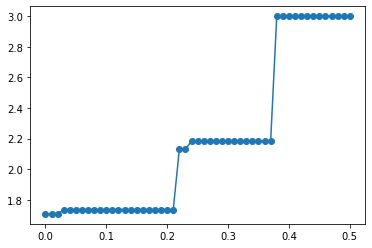

In [242]:
# Select a nice seed
# n=4 --> 938, 730 (unimodal) and 453 (multimodal sst)
# n=8 --> 820 (unimodal), 429, 392 (m=2), 703 (m=2)
softplus = torch.nn.Softplus(beta=1, threshold=20)
torch.manual_seed(1903) # 18, 283, 1903

n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

# Unimodal
m = 1
logits = torch.sort(torch.randn(n_items), descending=True)[0].numpy()
w = softplus(torch.tensor(logits)).numpy() #np.exp(logits)**m #np.array([np.exp(n_items-0)**m, np.exp(n_items-1)**m, np.exp(n_items-2)**m, np.exp(n_items-3)**m])
print(f"logits = {logits}, w = {w}")
p = proba_plackett_luce(w, all_ranks, n_items=n_items)
p_torch = torch.from_numpy(p)
P = pairwise_matrix(p_torch, torch_all_ranks, n=n_items)
print(p_torch)
print(P)

#Multimodal
#m=1
#logits1 = np.exp(torch.sort(torch.randn(n_items), descending=True)[0].numpy())
#w1 = np.power(list(np.exp(logits1)), m)
#logits2 = torch.randn(4).numpy()
#w2 = np.power(np.exp(logits2), m)
#logits3 = torch.randn(4).numpy()
#w3 = np.power(np.exp(logits3), m)
#p_torch, P = get_multimodal(ws=[w1, w2, w3], ratios=[1/3, 1/3, 1/3], all_ranks=all_ranks)
#print(f"w = {w}, p_torch = {p_torch}, P={P}")

# Two untied
#torch.manual_seed(279)
#p_torch = torch.zeros((1,24))

#logits = torch.sort(torch.randn(n_items), descending=True)[0].numpy()
#w = np.exp(logits)
#p = proba_plackett_luce(w, all_ranks, n_items=n_items)

#mixture_val = 0.95
#gap_mode = 0.1

#p_torch[0,0] += (0.5+gap_mode)
#p_torch[0,1] += (0.5-gap_mode)
#p_torch = mixture_val*p_torch + (1-mixture_val)*p
#P = pairwise_matrix(p_torch, torch_all_ranks, n=n_items)

print(p_torch, torch.sum(p_torch))

vals = list()
thresholds = np.linspace(0,0.5,51)
for i, threshold in enumerate(thresholds):
    print(f"i = {i}")
    Ptilde = maxpair(p_torch, torch_all_ranks, n=n_items, threshold = threshold)
    val = expected_kendall(Ptilde, P).detach().item()
    vals.append(val)

plt.plot(thresholds, vals, "o-")
plt.show()

In [ ]:
a = P[P > 0.5].reshape(-1)
print(a)
#torch.triu(P, 1).reshape(-1)
a = a[a!=0.0]
a = a-0.5+1e-4
a = torch.sort(a)[0][:3]
print(a)
shape_val = a.shape[0]-1

for i, a_ in enumerate(a):
    if i == 0:
        inter = torch.tensor(np.linspace(0, a_, 5)[1:])
        a = torch.cat((inter, a))
    elif int(i) >= shape_val:
        inter = torch.tensor(np.linspace(a_, a_+0.15, 4)[1:])
        #a = torch.cat((inter, a))
    else:
        inter = torch.tensor(np.linspace(a[i-1], a_, 5)[1:])
        a = torch.cat((inter, a))

In [ ]:
a = torch.unique(a)
a = torch.sort(a)[0]
a = a[a<0.5]
print(a, a.shape)

vals = list()
for i, threshold in enumerate(a):
    print(f"i = {i}")
    Ptilde = maxpair(p_torch, torch_all_ranks, n=n_items, threshold = threshold)
    val = expected_kendall(Ptilde, P).detach().item()
    vals.append(val)

plt.plot(a, vals, "o-")
plt.show()

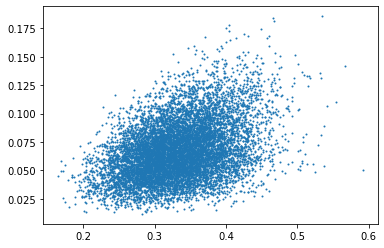

In [233]:
n_items = 4
all_ranks = list(itertools.permutations(list(np.arange(n_items))))
all_ranks = [np.array(elem) for elem in all_ranks]
torch_all_ranks = torch.from_numpy(np.asarray(all_ranks))

m = 1

list_tv_dist = list()
list_pair_dist = list()
for i in range(10000):
    #logits1 = torch.sort(torch.randn(n_items), descending=True)[0].numpy()
    #w1 = np.exp(logits1)**m
    #p1 = proba_plackett_luce(w1, all_ranks, n_items=n_items)
    p1 = np.random.uniform(size=24) 
    p1 /= p1.sum()
    p_torch1 = torch.from_numpy(p1)
    P1 = pairwise_matrix(p_torch1, torch_all_ranks, n=n_items)

    #logits2 = torch.sort(torch.randn(n_items), descending=True)[0].numpy()
    #w2 = np.exp(logits2)**m
    #p2 = proba_plackett_luce(w2, all_ranks, n_items=n_items)
    p2 = np.random.uniform(size=24) 
    p2 /= p2.sum()
    p_torch2 = torch.from_numpy(p2)
    P2 = pairwise_matrix(p_torch2, torch_all_ranks, n=n_items)

    list_tv_dist.append(torch.norm(p_torch1-p_torch2, 1)/2)
    list_pair_dist.append(torch.norm(P1-P2, 1)/(n_items*(n_items-1)))

plt.plot(list_tv_dist, list_pair_dist, "o", ms=1)
plt.show()

In [ ]:
plt.figure(figsize=(6,3))
plt.plot([1/2*list_tv_dist_ for list_tv_dist_ in list_tv_dist], list_pair_dist, "o", ms=3)
plt.title(f'Distances between proba vect. and pairwise mat.')
plt.xlabel(r'$TV(p_1,p_2)$')
plt.ylabel(r'$||P_1-P_2||_1$')
plt.tight_layout()
plt.savefig(f"/Users/m.goibert/Documents/Criteo/Projets_Recherche/P5_General_Depth_Fct/img_paper/proba_vs_pairwise.png", dpi=200)

In [ ]:
# Generate a distribution
m = 1
#print(all_ranks)

# For unimodal
torch.manual_seed(730)

logits = torch.sort(torch.randn(4), descending=True)[0].numpy()
w = np.exp(logits)**m #np.array([np.exp(n_items-0)**m, np.exp(n_items-1)**m, np.exp(n_items-2)**m, np.exp(n_items-3)**m])
print(w)
p = proba_plackett_luce(w, all_ranks)
p_torch = torch.from_numpy(p)

# For two untied
#w = np.array([np.exp(n_items-0)**m, np.exp(n_items-1)**m, np.exp(n_items-3)**(m-1), np.exp(n_items-2)**(m-1)])
#w = f"two_untied_m={m}"
#p_torch = torch.zeros((1,24))
#eps_distrib = 0.01
#p_torch[0,0] += 0.5 + m - 11*eps_distrib
#p_torch[0,1] += 0.5 - m - 11*eps_distrib
#for i in range(2,24):
#    p_torch[0,i] += eps_distrib
#print(p_torch, torch.sum(p_torch))


# For multimodal SST
#m1 = 2
#w1 = np.array([np.exp(n_items-0)**m1, np.exp(n_items-1)**m1, np.exp(n_items-2)**m1, np.exp(n_items-3)**m1]) # 1 > 2 > 3
#m2 = 1
#w2 = np.array([np.exp(n_items-1)**m2, np.exp(n_items-2)**m2, np.exp(n_items-0)**m2, np.exp(n_items-3)**m2]) # 3 > 1 > 2

#m3 = 1
#w3 = np.array([np.exp(n_items-2)**m3, np.exp(n_items-0)**m3, np.exp(n_items-1)**m3, np.exp(n_items-3)**m3]) # 2 > 3 > 1
#m4 = 100
#w4 = np.array([np.exp(n_items-2)**m4, np.exp(n_items-0)**m4, np.exp(n_items-1)**m4, np.exp(n_items-3)**m4]) #

#p_torch, P = get_multimodal(ws=[w1,w2,w3], ratios=[0.3,0.3,0.3], all_ranks=all_ranks)
#w = f"multimodal_m1={m1}_m2={m2}_m3={m3}"

print(p_torch)

# Other parameters
delta = 1
epochs = 20000
thresholds_ = np.linspace(0., 0.5, 21) #get_automatic_thresholds(w)
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
nb_simu_training = 25

In [ ]:
#w=[2.4557307, 2.4283485, 1.7044296, 1.2516327]
#p = proba_plackett_luce(w, all_ranks)
#p_torch = torch.from_numpy(p)

In [ ]:
logits1 = torch.sort(torch.randn(4), descending=True)[0].numpy()
w1 = np.exp(logits1) #np.array([np.exp(n_items-0)**m, np.exp(n_items-1)**m, np.exp(n_items-2)**m, np.exp(n_items-3)**m])
print(w)
p = proba_plackett_luce(w, all_ranks)
p_torch = torch.from_numpy(p)

### ERM

In [ ]:
# ERM
dist = "erm"
perf_list_erm, eps_list_erm1, eps_list_erm2, alt_eps_list_erm1, alt_eps_list_erm2, dict_res_training_erm = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)



In [ ]:
print(f"perf_list = {perf_list_erm} \n\n eps_list1 (l1 norm) = {eps_list_erm1} \n eps_list2 (l2 norm) = {eps_list_erm2} \n\n alt_eps_list1 (l1 norm) = {alt_eps_list_erm1} \n alt_eps_list2 (l2 norm) = {alt_eps_list_erm2}")

plt.plot(perf_list_erm, eps_list_erm1, '*')
plt.plot(perf_list_erm, eps_list_erm2, '*')
plt.plot(perf_list_erm, alt_eps_list_erm1, 'o')
plt.plot(perf_list_erm, alt_eps_list_erm2, 'o')
plt.show()

### Maxpair

In [ ]:
# Maxpair
dist = "maxpair"
perf_list_maxpair, eps_list_maxpair1, eps_list_maxpair2, alt_eps_list_maxpair1, alt_eps_list_maxpair2, dict_res_training_maxpair = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)

In [ ]:
print(f"perf_list = {perf_list_maxpair} \n\n eps_list1 (l1 norm) = {eps_list_maxpair1} \n eps_list2 (l2 norm) = {eps_list_maxpair2} \n\n alt_eps_list1 (l1 norm) = {alt_eps_list_maxpair1} \n alt_eps_list2 (l2 norm) = {alt_eps_list_maxpair2}")

plt.plot(perf_list_maxpair, eps_list_maxpair1, '*')
plt.plot(perf_list_maxpair, eps_list_maxpair2, '*')
plt.plot(perf_list_maxpair, alt_eps_list_maxpair1, 'o')
plt.plot(perf_list_maxpair, alt_eps_list_maxpair2, 'o')
plt.show()

### Merge

In [ ]:
# Merge
dist = "merge"
perf_list_merge, eps_list_merge1, eps_list_merge2, alt_eps_list_merge1, alt_eps_list_merge2, dict_res_training_merge = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)


In [ ]:
print(f"perf_list = {perf_list_merge} \n\n eps_list1 (l1 norm) = {eps_list_merge1} and eps_list2 (l2 norm) = {eps_list_merge2} \n\n alt_eps_list1 (l1 norm) = {alt_eps_list_merge1} and alt_eps_list2 (l2 norm) = {alt_eps_list_merge2}")

plt.plot(perf_list_merge, eps_list_merge1, '*')
plt.plot(perf_list_merge, eps_list_merge2, '*')
plt.plot(perf_list_merge, alt_eps_list_merge1, 'o')
plt.plot(perf_list_merge, alt_eps_list_merge2, 'o')
plt.show()

### Depth

In [ ]:
# Depth
dist = "depth"
perf_list_depth, eps_list_depth1, eps_list_depth2, alt_eps_list_depth1, alt_eps_list_depth2, dict_res_training_depth = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)

In [ ]:
print(f"perf_list = {perf_list_depth} and eps_list1 (l1 norm) = {eps_list_depth1} and eps_list2 (l2 norm) = {eps_list_depth2}")

plt.plot(perf_list_depth, eps_list_depth1, '*')
plt.plot(perf_list_depth, eps_list_depth2, '*')
plt.show()

### Wasserstein

In [ ]:
# Wasserstein
dist = "wasserstein"
perf_list_wasserstein, eps_list_wasserstein1, eps_list_wasserstein2, alt_eps_list_wasserstein1, alt_eps_list_wasserstein2, dict_res_training_wasserstein = launch_exp(dist, p_torch, w, delta, thresholds_, epochs, dist_type_sym=dist_type_sym, norm_type=norm_type, ratio_norm_=ratio_norm_, nb_simu_training=nb_simu_training)

In [ ]:
print(f"perf_list = {perf_list_wasserstein} and eps_list1 (l1 norm) = {eps_list_wasserstein1} and eps_list2 (l2 norm) = {eps_list_wasserstein2}")

plt.plot(perf_list_wasserstein, eps_list_wasserstein1, '*')
plt.plot(perf_list_wasserstein, eps_list_wasserstein2, '*')
plt.show()

# Load Old Experiments

In [ ]:
# Generate a distribution
m = 1
w = np.array([np.exp(n_items-0)**m, np.exp(n_items-1)**m, np.exp(n_items-2)**m, np.exp(n_items-3)**m])
print(w)
p = proba_plackett_luce(w, all_ranks)
p_torch = torch.from_numpy(p)

# Other parameters
delta = 1
epochs = 5000
thresholds_ = get_automatic_thresholds(w) #np.linspace(0., 0.5, 5)
dist_type_sym = False
norm_type = "1"
ratio_norm_ = 1.0
nb_simu_training = 25

In [ ]:
def get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_, folder_path=None):
    if folder_path == None:
        folder_path = f"{os.getcwd()}/perf_robustness_profile/"
    filename = f"perf_robustness_dist={dist}_w={w}_delta={delta}_epochs={epochs}_dist_type_sym={dist_type_sym}_norm_L{norm_type}_ratio_{ratio_norm_}.pt"
    return folder_path+filename

def load_plot_exp(path, dist, plot_training=False):
    dict_res = torch.load(mypath)
    training_dict = dict_res['training_dict']
    final_val_dict = dict_res['final_val_dict']
    
    # Check if there are several thresholds
    if 'threshold' in list(training_dict.keys())[0]:
        perf_list_all = list()
        eps_list1_all = list()
        eps_list2_all = list()
        thresholds = [float(a_.split('_')[1]) for a_ in list(training_dict.keys())]
        for (threshold, key) in zip(thresholds, list(training_dict.keys())):
            dist_Tp_Tq = lambda _p,_q: torch_dist(dist, _p, _q, torch_all_ranks, threshold=threshold, dist_type_sym=dist_type_sym)
            if plot_training:
                plot_end_training(p_torch=p_torch, dist_Tp_Tq=dist_Tp_Tq, norms_=training_dict[key]['norms'], losses=training_dict[key]['losses'], mean_qs_=training_dict[key]['mean_qs'], phis_=training_dict[key]['phis'], mean_phi2_=training_dict[key]['mean_phi2'], lambdas_=training_dict[key]['lambdas'], mean_lambdas_=training_dict[key]['mean_lambdas'], grad_data=training_dict[key]['grad_data'], freq_phi_=training_dict[key]['freq_phi'], norm_type=norm_type)
            perf_list = final_val_dict[key]['perf_list']
            eps_list1 = final_val_dict[key]['eps_list1']
            eps_list2 = final_val_dict[key]['eps_list2']
            
            print(f"perf_list = {perf_list} \n and eps_list1 (l1 norm) = {eps_list1}  \n and eps_list2 (l2 norm) = {eps_list2}")

            plt.plot(perf_list, eps_list1, '*')
            plt.plot(perf_list, eps_list2, '*')
            plt.show()
            
            perf_list_all.append(perf_list)
            eps_list1_all.append(eps_list1)
            eps_list2_all.append(eps_list2)
        return perf_list_all, eps_list1_all, eps_list2_all, thresholds
    else:
        dist_Tp_Tq = lambda _p,_q: torch_dist(dist, _p, _q, torch_all_ranks, threshold=0, dist_type_sym=dist_type_sym)
        if plot_training:
            plot_end_training(p_torch=p_torch, dist_Tp_Tq=dist_Tp_Tq, norms_=training_dict['norms'], losses=training_dict['losses'], mean_qs_=training_dict['mean_qs'], phis_=training_dict['phis'], mean_phi2_=training_dict['mean_phi2'], lambdas_=training_dict['lambdas'], mean_lambdas_=training_dict['mean_lambdas'], grad_data=training_dict['grad_data'], freq_phi_=training_dict['freq_phi'], norm_type=norm_type)
        perf_list = final_val_dict['perf_list']
        eps_list1 = final_val_dict['eps_list1']
        eps_list2 = final_val_dict['eps_list2']

        print(f"perf_list = {perf_list} \n and eps_list1 (l1 norm) = {eps_list1}  \n and eps_list2 (l2 norm) = {eps_list2}")

        plt.plot(perf_list, eps_list1, '*')
        plt.plot(perf_list, eps_list2, '*')
        plt.show()
        return perf_list, eps_list1, eps_list2, [0]
        
    
    

In [ ]:
dist = "erm"
mypath = get_path_exp(dist, w, delta, epochs, dist_type_sym, norm_type, ratio_norm_)
#dict_res_erm = torch.load(mypath)
perf_list, eps_list1, eps_list2, thresholds = load_plot_exp(mypath, dist)
print(f"perf = {perf_list} \n l1 norm diff = {eps_list1} \n l2 norm diff = {eps_list2}")

# Plot all results

In [ ]:
plt.plot(perf_list_erm, alt_eps_list_erm1, 'x', label="ERM")
plt.plot(perf_list_merge, alt_eps_list_merge1, 'o', label="Merge")
plt.plot(perf_list_maxpair, alt_eps_list_maxpair1, '*', label="Maxpair")
#plt.plot(perf_list_depth, eps_list_depth2, 's', label="Depth")
plt.xlabel("Performance (loss)")
plt.ylabel("Robustness (bkdwn pts)")
#plt.ylim(-0.05, 1.05)
plt.legend()
plt.show()